## Animations for my slides

```
-q, --quality [l|m|h|p|k]      Render quality at the follow resolution
                                 framerates, respectively: 854x480 15FPS,
                                 1280x720 30FPS, 1920x1080 60FPS, 2560x1440
                                 60FPS, 3840x2160 60FPS
 -t, --transparent              Render scenes with alpha channel.
```

In [2]:
from manim import *
import networkx as nx
import numpy as np

Hmmm, a bit trickier than I thought.

Are all the fluid cells uniform in density etc (euler equations). Why is that no reflected with the danteComparisonSim?

Manim Community v0.18.1

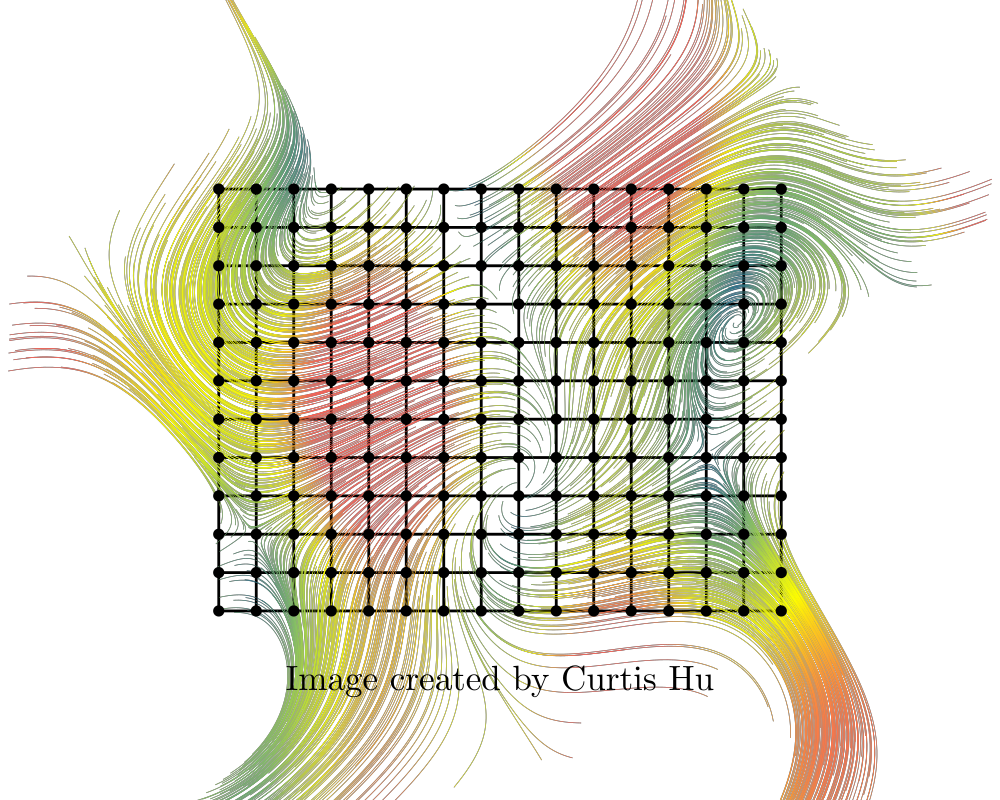

In [299]:
%%manim -qm -vWARNING -r1000,800 EulerianFlowField

class EulerianFlowField(Scene):
    def construct(self):
        self.camera.background_color = "#ffffff"

        # FLUID FIELD
        func = lambda pos: np.sin(pos[0]) * UR + np.cos(pos[1]) * LEFT + pos / 5

        stream_lines = StreamLines(
            func, x_range=[-4, 4, 0.2], y_range=[-3, 3, 0.2]
        )

        self.add(stream_lines)
        # stream_lines.start_animation(warm_up=True, flow_speed=1.0, time_width=2.0)

        # CREATE LAYOUT
        W, H = 16, 12
        assert W > 1 and H > 1

        width, height = 4, 3 # width in cartesion coordinate system


        # ADD GRAPH
        vertices = np.arange(W*H).reshape((H, W)) # NodeID
        edges = []
        for i in range(H):
            for v1, v2 in zip(vertices[i,:], vertices[i,1:]):
                edges.append((v1, v2))
        for j in range(W):
            for v1, v2 in zip(vertices[:, j], vertices[1:,j]):
                edges.append((v1, v2))
        
        positions = {}
        scale = 2

        rectGroup = VGroup()
        for i, row in enumerate(vertices):
            for j, col in enumerate(row):
                # col is NodeID (index)
                positions[col] = scale * np.array([
                    j * (width / (W-1)) - (width/2),
                    i * (height / (H-1)) - (height/2),
                    0])
                if i > 0 and j > 0:
                    vert = [ positions[vertices[i+k, j+m]] for k, m in [(0, 0), (0, -1), (-1, -1), (-1, 0)] ]
                    rectGroup.add(Polygram(vert, color=BLUE, fill_opacity=1))

                

        def custom_layout(graph: nx.Graph, scale=1, *args, **kwargs):
            return positions

        g = Graph(vertices.flatten(), edges, vertex_config={"color": BLACK}, edge_config={"color": BLACK}, layout=custom_layout)
        self.add(g)

        self.add(Tex("Image created by Curtis Hu", color=BLACK).shift(DOWN*4))


        # Fill in with rects.
        # self.remove(g)
        # self.play(FadeIn(rectGroup))
        # self.play(Create(g), lag_ratio=0.1, run_time=4)
        # self.wait()


        # self.play(Write(Tex("Cutting up the fluid into discrete pieces")))
        # self.play(Write(Tex("Now, we've allowed computers to apply finite difference equations")))
        # self.play(Write(Tex("In other words, our partial difference conservation equations can apply")))

        



        

Manim Community v0.18.1

0 -100


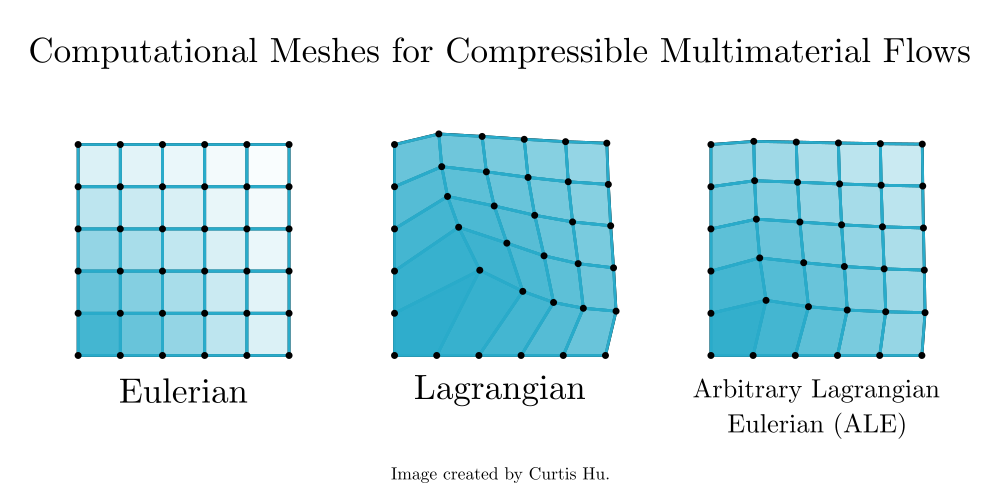

In [274]:
%%manim -qm -vWARNING -r1000,500 GraphicMeshes


def fbm(x, y):
    f = 1
    A = 1
    res = 0
    for i in range(6):
        res += A*np.sin(f*y)*np.cos(f*x)
        f*=1.2
        A*=0.5
    return abs(res)

class GraphicMeshes(Scene):
    def construct(self):
        self.camera.background_color = "#ffffff"

        title = Tex("Computational Meshes for Compressible Multimaterial Flows", color=BLACK).shift(UP*2.8)
        self.add(title)

        #########################
        # EULERIAN
        #########################
        W, H = 6, 6
        assert W > 1 and H > 1

        width, height = 1.5, 1.5 # width in cartesion coordinate system


        # ADD GRAPH
        vertices = np.arange(W*H).reshape((H, W)) # NodeID
        edges = []
        for i in range(H):
            for v1, v2 in zip(vertices[i,:], vertices[i,1:]):
                edges.append((v1, v2))
        for j in range(W):
            for v1, v2 in zip(vertices[:, j], vertices[1:,j]):
                edges.append((v1, v2))
        
        positions = {}
        originalPositions = {}
        scale = 2



        rects = {}
        eulerianRectGroup = VGroup(z_index=-100)
        for i, row in enumerate(vertices):
            for j, col in enumerate(row):
                # col is NodeID (index)
                positions[col] = scale * np.array([
                    j * (width / (W-1)) - (width/2),
                    i * (height / (H-1)) - (height/2),
                    0])
                originalPositions[col] = positions[col]*1
                if i > 0 and j > 0:
                    vert = [ positions[vertices[i+k, j+m]] for k, m in [(0, 0), (0, -1), (-1, -1), (-1, 0)] ]

                    rad = np.sqrt(i*i + j*j) / np.sqrt(W*W + H*H)
                    E = np.exp(-5*rad*rad)

                    rects[col] = Polygram(vert, color=BLUE_D, fill_opacity=E)
                    eulerianRectGroup.add(rects[col])
                

        eulerian = Graph(vertices.flatten(), edges, layout=lambda *args, **kwargs: positions,
                            vertex_config={
                                "color": BLACK,
                                "radius": 0.05
                            }, 
                            edge_config={
                                "color": BLACK,
                            })

        eLabel = Tex("Eulerian", color=BLACK)

        eLabel.shift(LEFT*4.5 + DOWN*2)
        eulerian.shift(LEFT*4.5 + DOWN*0)
        eulerianRectGroup.shift(LEFT*4.5+DOWN*0)

        self.add(eulerianRectGroup)
        self.add(eLabel)
        self.add(eulerian)

        print(eulerian.z_index, eulerianRectGroup.z_index)


        #########################
        # LAGRANGE
        #########################

        origin = positions[0]
        removedBoundaryVertices = vertices[1:, 1:]
        for n in removedBoundaryVertices.flatten():
            r = np.linalg.norm(positions[n]-origin)
            unitVec = (positions[n]-origin) / r

            percent = np.exp(-0.2*r*r)

            positions[n] += percent*unitVec
        
        lagrangian = Graph(vertices.flatten(), edges, layout=lambda *args, **kwargs: positions,
                            vertex_config={
                                "color": BLACK,
                                "radius": 0.05
                            }, 
                            edge_config={
                                "color": BLACK,
                            })
        lLabel = Tex("Lagrangian", color=BLACK).shift(DOWN*2)

        lagRectGroup = VGroup()
        for i in range(1, H):
            for j in range(1, W):
                vert = [ positions[vertices[i+k, j+m]] for k, m in [(0, 0), (0, -1), (-1, -1), (-1, 0)] ]
                rad = np.sqrt(i*i + j*j) / np.sqrt(W*W + H*H)
                E = np.exp(-1*rad*rad)
                lagRectGroup.add(Polygram(vert, color=BLUE_D, fill_opacity=E))


        # lagRectGroup.shift(DOWN)
        # lagrangian.shift(DOWN)

        self.add(lagRectGroup)
        self.add(lagrangian)
        self.add(lLabel)


        #########################
        # ALE
        #########################

        for n in vertices.flatten():
            positions[n] += 0.7*(originalPositions[n]-positions[n]) 

        ale = Graph(vertices.flatten(), edges, layout=lambda *args, **kwargs: positions,
                            vertex_config={
                                "color": BLACK,
                                "radius": 0.05
                            }, 
                            edge_config={
                                "color": BLACK,
                            })

        aleRectGroup = VGroup()
        for i in range(1, H):
            for j in range(1, W):
                vert = [ positions[vertices[i+k, j+m]] for k, m in [(0, 0), (0, -1), (-1, -1), (-1, 0)] ]
                rad = np.sqrt(i*i + j*j) / np.sqrt(W*W + H*H)
                E = np.exp(-2*rad*rad)
                aleRectGroup.add(Polygram(vert, color=BLUE_D, fill_opacity=E))

        aLabel = VGroup(
            Tex("Arbitrary Lagrangian", color=BLACK, font_size=36).shift(RIGHT*4.5 + DOWN*2),
            Tex("Eulerian (ALE)", color=BLACK, font_size=36).shift(RIGHT*4.5 + DOWN*2.5)
        )
        ale.shift(RIGHT*4.5)
        aleRectGroup.shift(RIGHT*4.5)
        

        self.add(aleRectGroup)
        self.add(ale)
        self.add(aLabel)



        #########################
        # citation
        #########################
        self.add(Tex("Image created by Curtis Hu.", color=BLACK, font_size=24).shift(DOWN*3.2))



        

Manim Community v0.18.1

[0 1 2 3 4 5 6 7]


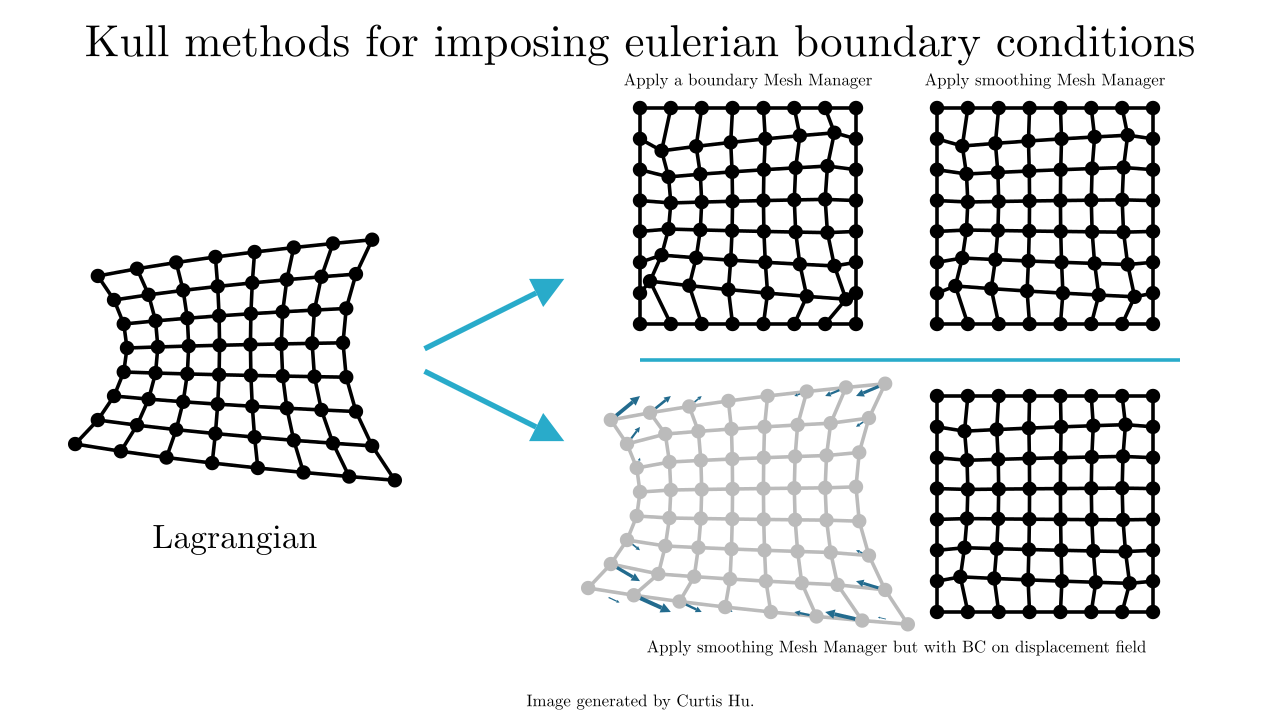

In [288]:
%%manim -qm -vWARNING MeshCycle

class MeshCycle(Scene):
    def construct(self):
        self.camera.background_color = "#ffffff"

        self.add(Tex("Kull methods for imposing eulerian boundary conditions", color=BLACK).shift(UP*3.5))


        ######################################3
        # stuff
        ######################################3
        W, H = 8, 8
        assert W > 1 and H > 1

        width, height = 1.2, 1.2 # width in cartesion coordinate system

        vertices = np.arange(W*H).reshape((H, W)) # NodeID
        edges = []
        for i in range(H):
            for v1, v2 in zip(vertices[i,:], vertices[i,1:]):
                edges.append((v1, v2))
        for j in range(W):
            for v1, v2 in zip(vertices[:, j], vertices[1:,j]):
                edges.append((v1, v2))
        
        originalPositions = {}
        positions = {}
        scale = 2


        eulerianRectGroup = VGroup(z_index=-100)
        for i, row in enumerate(vertices):
            for j, col in enumerate(row):
                # col is NodeID (index)
                originalPositions[col] = scale * np.array([
                    j * (width / (W-1)) - (width/2),
                    i * (height / (H-1)) - (height/2),
                    0])
                
                positions[col] = originalPositions[col] * np.array([0.03*np.square(i-H/2)+1, np.log10(j+6), 0])

                if i > 0 and j > 0:
                    vert = [ positions[vertices[i+k, j+m]] for k, m in [(0, 0), (0, -1), (-1, -1), (-1, 0)] ]
                    
                    percent = j / W
                    blue, red = np.array([0, 0, 128]), np.array([210, 4, 48])
                    col = blue + percent * (red - blue)

                    eulerianRectGroup.add(Polygram(vert, color=col, fill_opacity=1))

        ############
        # Lagrange
        ############
        positionsAfterLagrange = positions.copy()

        lagrange = Graph(vertices.flatten(), edges, layout=lambda *args, **kwargs: positions,
                            vertex_config={
                                "color": BLACK,
                                "radius": 0.08
                            }, 
                            edge_config={
                                "color": BLACK,
                            })

        lLabel = VGroup(
            Tex("Lagrangian", color=BLACK, font_size=36).shift(LEFT*4.5 + DOWN*2),
        )
        lagrange.shift(LEFT*4.5)

        self.add(lagrange)
        self.add(lLabel)

        self.add(
            VGroup(
                Arrow(end=(UP + RIGHT), color=BLUE_D),
                Arrow(end=(DOWN + RIGHT), color=BLUE_D)
            ).arrange(DOWN).next_to(lagrange))

        ###########################
        # SECTION ABOVE
        ###########################
        
        # displacement field
        boundaryNodes = np.concatenate([vertices[0,:], (vertices[-1,:]), vertices[:,0], vertices[:,-1]])
        print(vertices[0, :])
        for n in boundaryNodes:
            positions[n] = originalPositions[n]

        boundary = Graph(vertices.flatten(), edges, layout=lambda *args, **kwargs: positions,
                            vertex_config={
                                "color": BLACK,
                                "radius": 0.08
                            }, 
                            edge_config={
                                "color": BLACK,
                            })
        boundary.shift(UP*1.6 + RIGHT*1.2)
        bLabel = Tex("Apply a boundary Mesh Manager", font_size=18, color=BLACK).shift(RIGHT*1.2+UP*3.1)

        self.add(bLabel)
        self.add(boundary)

        for n in vertices.flatten():
            positions[n] += 0.4 * (originalPositions[n] - positions[n])

        afterale = Graph(vertices.flatten(), edges, layout=lambda *args, **kwargs: positions,
                            vertex_config={
                                "color": BLACK,
                                "radius": 0.08
                            }, 
                            edge_config={
                                "color": BLACK,
                            })
        afterale.shift(RIGHT*4.5 + UP*1.6)
        aleLabel = Tex("Apply smoothing Mesh Manager", font_size=18, color=BLACK).shift(RIGHT*4.5 + UP*3.1)

        self.add(aleLabel)
        self.add(afterale)


        # DIVIDING LINE
        self.add(Line(start=[0, 0, 0], end=[6, 0, 0], color=BLUE_D))


        ###########################
        # LOWER SECTION BELOW LINE 
        ###########################

        generic = Graph(vertices.flatten(), edges, layout=lambda *args, **kwargs: positionsAfterLagrange,
                            vertex_config={
                                "color": GRAY_B,
                                "radius": 0.08
                            }, 
                            edge_config={
                                "color": GRAY_B,
                            })

        # for generating arrows we need to know ultimate state
        originalAfterLagrange = positionsAfterLagrange.copy()
        offset = DOWN*1.6 + RIGHT*1.2
        generic.shift(offset)
        for n in vertices.flatten():
            if n in boundaryNodes:
                positionsAfterLagrange[n] = originalPositions[n]
            positionsAfterLagrange[n] += 0.4 * (originalPositions[n] - positionsAfterLagrange[n])
            self.add(Arrow(start=originalAfterLagrange[n], end=positionsAfterLagrange[n], color=BLUE_E, max_stroke_width_to_length_ratio=10).shift(offset))


        gLabel = Tex("Apply smoothing Mesh Manager but with BC on displacement field", font_size=18, color=BLACK).shift(RIGHT*2.85+DOWN*3.2)
        
        self.add(gLabel)
        self.add(generic)


        bccond = Graph(vertices.flatten(), edges, layout=lambda *args, **kwargs: positionsAfterLagrange,
                            vertex_config={
                                "color": BLACK,
                                "radius": 0.08
                            }, 
                            edge_config={
                                "color": BLACK,
                            })
        bccond.shift(RIGHT*4.5 + DOWN*1.6)
        self.add(bccond)


        # CITATION

        curtis = Tex("Image generated by Curtis Hu.", font_size=18, color=BLACK).shift(DOWN*3.8)
        self.add(curtis)




Manim Community v0.18.1

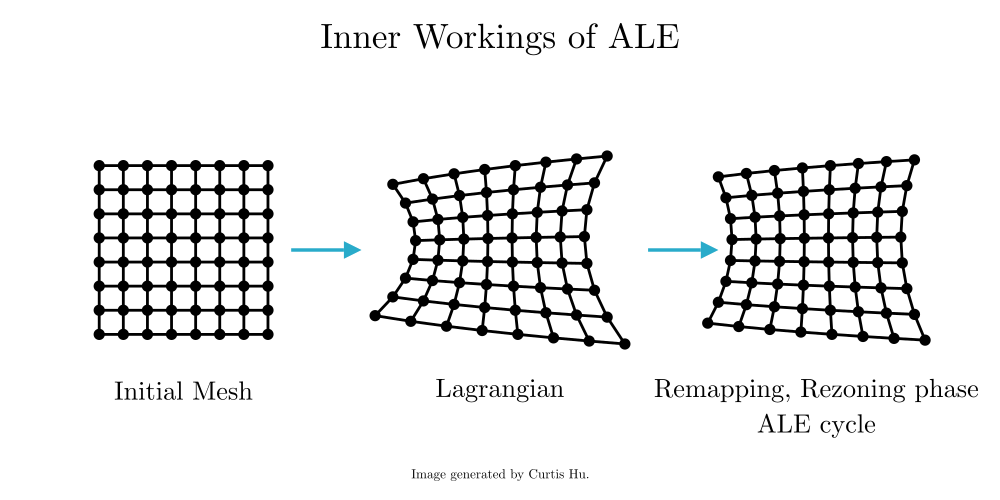

In [290]:
%%manim -qm -vWARNING -r1000,500 MeshCycle

class MeshCycle(Scene):
    def construct(self):
        self.camera.background_color = "#ffffff"

        self.add(Tex("Inner Workings of ALE", color=BLACK).shift(UP*3))

        ######################################3
        # stuff
        ######################################3
        W, H = 8, 8
        assert W > 1 and H > 1

        width, height = 1.2, 1.2 # width in cartesion coordinate system

        vertices = np.arange(W*H).reshape((H, W)) # NodeID
        edges = []
        for i in range(H):
            for v1, v2 in zip(vertices[i,:], vertices[i,1:]):
                edges.append((v1, v2))
        for j in range(W):
            for v1, v2 in zip(vertices[:, j], vertices[1:,j]):
                edges.append((v1, v2))
        
        originalPositions = {}
        positions = {}
        scale = 2


        eulerianRectGroup = VGroup(z_index=-100)
        for i, row in enumerate(vertices):
            for j, col in enumerate(row):
                # col is NodeID (index)
                originalPositions[col] = scale * np.array([
                    j * (width / (W-1)) - (width/2),
                    i * (height / (H-1)) - (height/2),
                    0])
                
                positions[col] = originalPositions[col] * np.array([0.03*np.square(i-H/2)+1, np.log10(j+6), 0])

                if i > 0 and j > 0:
                    vert = [ positions[vertices[i+k, j+m]] for k, m in [(0, 0), (0, -1), (-1, -1), (-1, 0)] ]
                    
                    percent = j / W
                    blue, red = np.array([0, 0, 128]), np.array([210, 4, 48])
                    col = blue + percent * (red - blue)

                    eulerianRectGroup.add(Polygram(vert, color=col, fill_opacity=1))

        ############
        # Euler
        ############
        eulerian = Graph(vertices.flatten(), edges, layout=lambda *args, **kwargs: originalPositions,
                            vertex_config={
                                "color": BLACK,
                                "radius": 0.08
                            }, 
                            edge_config={
                                "color": BLACK,
                            })

        eLabel = VGroup(
            Tex("Initial Mesh", color=BLACK, font_size=36).shift(LEFT*4.5 + DOWN*2),
        )
        eulerian.shift(LEFT*4.5)

        self.add(eulerian)
        self.add(eLabel)
        self.add(Arrow(end=(RIGHT*0.5), color=BLUE_D).next_to(eulerian))

        ############
        # Lagrange
        ############
        positionsAfterLagrange = positions.copy()

        lagrange = Graph(vertices.flatten(), edges, layout=lambda *args, **kwargs: positions,
                            vertex_config={
                                "color": BLACK,
                                "radius": 0.08
                            }, 
                            edge_config={
                                "color": BLACK,
                            })

        lLabel = VGroup(
            Tex("Lagrangian", color=BLACK, font_size=36).shift(DOWN*2),
        )

        self.add(lagrange)
        self.add(lLabel)

        self.add(Arrow(end=(RIGHT)*0.5, color=BLUE_D).next_to(lagrange))

        ###########################
        # SECTION ABOVE
        ###########################
        
        # displacement field
        # boundaryNodes = np.concatenate([vertices[0,:], (vertices[-1,:]), vertices[:,0], vertices[:,-1]])
        # print(vertices[0, :])
        # for n in boundaryNodes:
        #     positions[n] = originalPositions[n]
        for n in vertices.flatten():
            positions[n] += 0.4 * (originalPositions[n] - positions[n])

        afterale = Graph(vertices.flatten(), edges, layout=lambda *args, **kwargs: positions,
                            vertex_config={
                                "color": BLACK,
                                "radius": 0.08
                            }, 
                            edge_config={
                                "color": BLACK,
                            })
        afterale.shift(RIGHT*4.5)
        aleLabel = Tex("Remapping, Rezoning phase", font_size=36, color=BLACK).shift(RIGHT*4.5 + DOWN*2)
        aleLabel2 = Tex("ALE cycle", font_size=36, color=BLACK).shift(RIGHT*4.5 + DOWN*2.5)

        self.add(aleLabel, aleLabel2, afterale)

        # CITATION

        curtis = Tex("Image generated by Curtis Hu.", font_size=18, color=BLACK).shift(DOWN*3.2)
        self.add(curtis)




In [14]:
%%manim -qm -vWARNING EulerianFlowField

class EulerianFlowField(Scene):
    def construct(self):
        self.camera.background_color = "#ffffff"

        N = 15
        rectGroups = VGroup(*[Square(side_length=1.0, color=BLACK) for s in range(N)])
        
        rectGroups.arrange_in_grid(buff=0)

        self.add(rectGroups)
        self.wait()

Manim Community v0.18.1

In [88]:
%%manim -qm -vWARNING EulerianFlowField

class EulerianFlowField(Scene):
    def construct(self):
        self.camera.background_color = "#ffffff"

        plane = NumberPlane(
            faded_line_ratio=1,
            axis_config={
                "stroke_color": TEAL,
                "stroke_width": 4,
                "stroke_opacity": 0.6

        })
        self.add(plane)
        self.wait()

Manim Community v0.18.1

In [ ]:
%%manim -qm -vWARNING -r500,500 LagrangianFlowField

class LagrangianFlowField(Scene):
    def construct(self):
        self.camera.background_color = "#ffffff"

        # FLUID FIELD
        func = lambda pos: np.sin(pos[0]) * UR + np.cos(pos[1]) * LEFT + pos / 5

        stream_lines = StreamLines(
            func, x_range=[-4, 4, 0.2], y_range=[-3, 3, 0.2]
        )

        self.add(stream_lines)
        stream_lines.start_animation(warm_up=True, flow_speed=1.0, time_width=2.0)
        self.wait(5)

        # CREATE LAYOUT
        W, H = 8, 6
        assert W > 1 and H > 1

        width, height = 4, 3 # width in cartesion coordinate system


        # ADD GRAPH
        vertices = np.arange(W*H).reshape((H, W)) # NodeID
        edges = []
        for i in range(H):
            for v1, v2 in zip(vertices[i,:], vertices[i,1:]):
                edges.append((v1, v2))
        for j in range(W):
            for v1, v2 in zip(vertices[:, j], vertices[1:,j]):
                edges.append((v1, v2))
        
        positions = {}
        scale = 2

        for i, row in enumerate(vertices):
            for j, col in enumerate(row):
                # col is NodeID (index)
                positions[col] = scale * np.array([
                    j * (width / (W-1)) - (width/2),
                    i * (height / (H-1)) - (height/2),
                    0])
                if i > 0 and j > 0:
                    vert = [ positions[vertices[i+k, j+m]] for k, m in [(0, 0), (0, -1), (-1, -1), (-1, 0)] ]
                    rectGroup.add(Polygram(vert, color=BLUE, fill_opacity=1))

                

        def custom_layout(graph: nx.Graph, scale=1, *args, **kwargs):
            return positions

        g = Graph(vertices.flatten(), edges, vertex_config={"color": BLACK}, edge_config={"color": BLACK}, layout=custom_layout)
        self.play(Create(g), lag_ratio=0.1, run_time=4)
        self.wait()

In [ ]:
%%manim -qm -vWARNING ALEFlowField

class ALEFlowField(Scene):
    def construct(self):
        circle = Circle(radius=1, color=BLUE)
        self.play(GrowFromCenter(circle))
        self.wait()

In [ ]:
%%manim -qm -vWARNING Thumbnail

class Thumbnail(Scene):
    def construct(self):
        circle = Circle(radius=1, color=BLUE)
        self.play(GrowFromCenter(circle))
        self.wait()